<a href="https://colab.research.google.com/github/Vasanta2002/sprint_7/blob/main/JDS_SHR_234_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### BloomTech Data Science


---

# Model Interpretation

- Visualize and interpret **partial dependence plots**
- Explain individual predictions with **shapley value plots**


In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

In [3]:
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [5]:
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

In [6]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [7]:
pd.set_option('display.max_columns', 500)

# I. Wrangle Data

In [8]:
def wrangle(filepath):

  df = pd.read_csv(filepath)

  # Set issue date to index
  df = pd.read_csv(filepath, parse_dates=['issue_d']).sort_index()
  
  # subset data to 36-month loans
  mask = df['term'].str.strip() == '36 months'
  df = df[mask]
  df.drop(columns='term', inplace=True)

  # Turn `'int_rate'` col into float
  df['int_rate'] = df['int_rate'].str.strip(' %').astype(float)

    
  # Consolidate and OHE loan purpose (`'title'`)
  df['title']
  
  keywords = ['business', 'consolidation|credit', 'home', 'car|vacation|medical|moving']
  for col in keywords:
    df[col] = (df['title']
               .fillna('')
               .str.lower()
               .str.contains(col, regex=True)
               .astype(int))
  

  columns_to_keep = keywords + ['annual_inc','funded_amnt','int_rate','fico_range_high']
  
  
  df = df[columns_to_keep]
  
  # Rename columns
  # df.rename(columns={'annual_inc': 'annual_income',
  #                   'business': 'purpose_business',
  #                   'car|vacation|medical|moving': 'purpose_major_purchase',
  #                   'consolidation|credit': 'purpose_consolidation',
  #                   'fico_range_high': 'credit_score',
  #                   'funded_amnt': 'loan_amount',
  #                   'home': 'purpose_home_purchase',
  #                   'int_rate': 'interest_rate'}, inplace=True)
  return df

df = wrangle(DATA_PATH+'lending-club/lending-club-subset.csv')

In [9]:
df.shape

(102996, 8)

In [10]:
df.head()

,business,consolidation|credit,home,car|vacation|medical|moving,annual_inc,funded_amnt,int_rate,fico_range_high
0,0,1,0,0,99500.0,20000.0,9.44,694.0
1,0,1,0,0,79000.0,21600.0,9.80,684.0
2,0,0,1,0,90100.0,25000.0,17.57,699.0
3,0,1,0,1,110139.0,5000.0,6.89,719.0
4,0,1,0,1,50500.0,11850.0,14.16,674.0


# II. Split Data

In [11]:
# Split our data in feature matrix and target vector
target = 'int_rate'
X = df.drop(columns=target)
y = df[target]


In [12]:
# Split data into training, validation, test sets
# Because this is datetime data, we'll do a cutoff
# sort_index is the key here! take tail as test data! 

# numpy array slicing syntax

X_train, y_train = X[:-20_000], y[:-20_000]
X_val, y_val = X[-20_000:-10_000], y[-20_000:-10_000]
X_test, y_test = X[-10_000:], y[-10_000:]

# III. Establish Baseline

In [13]:
print('Mean interest rate:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean interest rate: 11.63083172683021
Baseline MAE: 2.975653413147899


# IV. Build Model

In [14]:
# not using any pipelines

model_lr = LinearRegression()
model_r = Ridge()
model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
model_xgb = XGBRegressor(random_state=42, n_jobs=-1)

In [15]:
model_lr.fit(X_train, y_train);
model_r.fit(X_train, y_train);
model_rf.fit(X_train, y_train);
model_xgb.fit(X_train, y_train);

[01:48:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


# V. Check Metrics

In [16]:
def check_metrics(model):
  print('Training MAE:', mean_absolute_error(y_train, model.predict(X_train)))
  print('Validation MAE:', mean_absolute_error(y_val, model.predict(X_val)))
  print('Validation R^2:', model.score(X_val, y_val))
  print()
  print()

models = [model_lr, model_r, model_rf, model_xgb]

for m in models:
  check_metrics(m)

Training MAE: 2.471015556374153
Validation MAE: 2.4302818691744563
Validation R^2: 0.29140996030478217


Training MAE: 2.471016381989963
Validation MAE: 2.4302828300285597
Validation R^2: 0.2914103153889407


Training MAE: 1.1927929950722722
Validation MAE: 2.5205286302276213
Validation R^2: 0.22092928813593793


Training MAE: 2.3533426092816483
Validation MAE: 2.3143439933662417
Validation R^2: 0.3473989329118108




# VI. Communicate Results

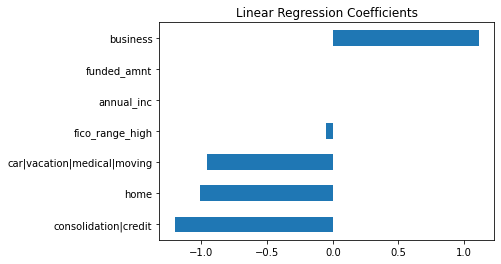

In [18]:
coefficients = model_lr.coef_
coef = pd.DataFrame(data=coefficients, index=X_train.columns,columns=['coefficients'])
coef['coefficients'].sort_values().plot(kind='barh');
plt.title('Linear Regression Coefficients')
plt.show()

In [19]:
coef

,coefficients
business,1.114398
consolidation|credit,-1.204349
home,-1.012562
car|vacation|medical|moving,-0.961522
annual_inc,-0.000004
funded_amnt,0.000021
fico_range_high,-0.054321


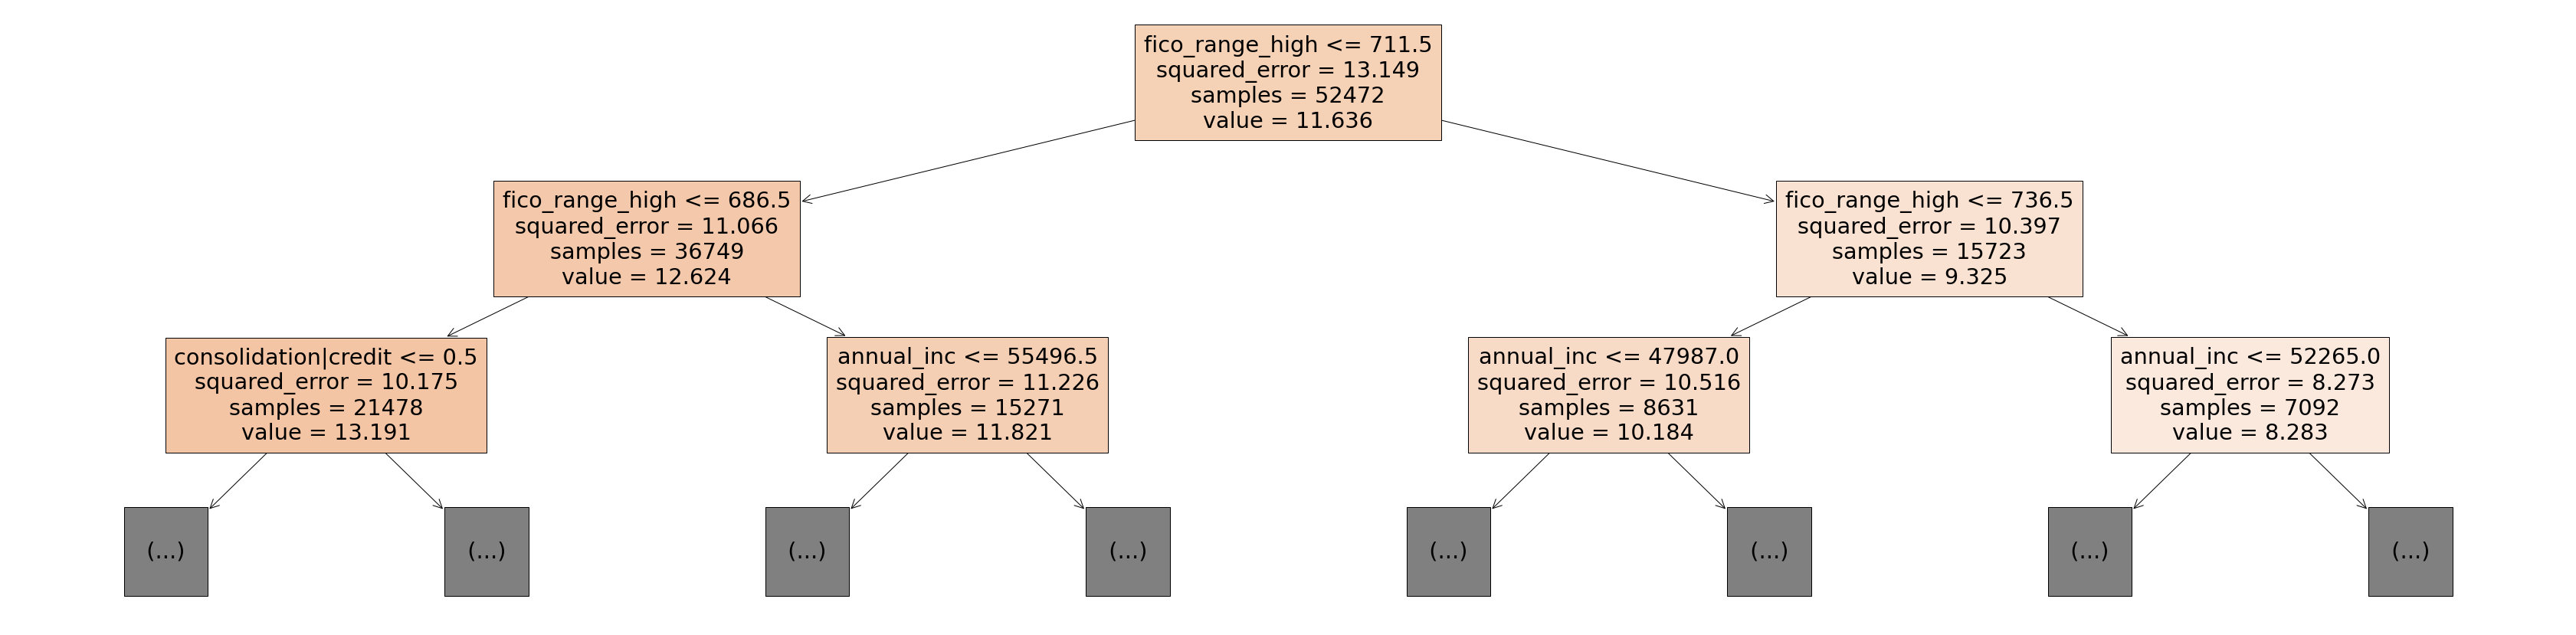

In [23]:
from sklearn.tree import plot_tree

plt.figure(figsize=(60,15))

plot_tree(
     model_rf.estimators_[0],
     max_depth=2,
     feature_names=X_train.columns,
     filled=True
);

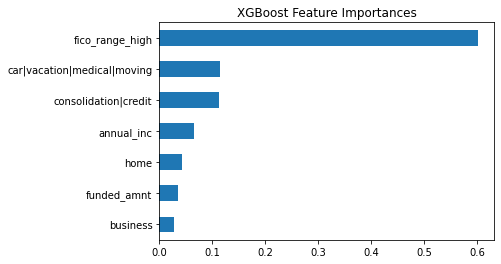

In [24]:
importances = model_xgb.feature_importances_
imp = pd.DataFrame(data=importances, index=X_train.columns, columns=['coefficients'])
imp['coefficients'].sort_values().plot(kind='barh');
plt.title('XGBoost Feature Importances')
plt.show()

## Partial Dependence Plots

One Feature

In [ ]:
# select one feature

In [ ]:
# create an instance of PDP Isolate.

Two features

In [ ]:
# select two features

In [ ]:
# create an instance of PDP Interact.


## Shapley Plots

In [ ]:
#select one sample/observation

In [ ]:
# Shapley Force Plot
# This may not work well in local notebooks
# you may need to install ipywidgets

#initialization of java script

